In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.layers import Dense
import numpy as np
# 这个是没有限制用药数量的文件
df = pd.read_csv(r'C:\Users\pinkpigma\pinkpigma的同步盘\KDD研二上\可解释性框架-工作\数据\patient_diagnoses2000_ndc300_with_history_delete1.csv')

In [2]:
# 预测第一天用药
x = df.iloc[:,5:5+72+2000]
y = df.iloc[:,5+72+2000:5+72+2000+300]

x

,heartrate_min,heartrate_max,heartrate_mean,sysbp_min,sysbp_max,sysbp_mean,diasbp_min,diasbp_max,diasbp_mean,meanbp_min,...,0543,2181,2550,86813,99631,E8500,1129,1504,76409,7703
0,90.0,124.0,111.760000,110.0,201.0,177.041667,62.0,107.0,90.666667,75.000000,...,0,0,0,0,0,0,0,0,0,0
1,69.0,104.0,79.441176,77.0,146.0,109.468750,36.0,91.0,57.593750,47.000000,...,0,0,0,0,0,0,0,0,0,0
2,95.0,127.0,111.958333,113.0,149.0,127.652174,50.0,89.0,68.782609,77.333298,...,0,0,0,0,0,0,0,0,0,0
3,58.0,92.0,78.478261,88.0,132.0,114.833333,45.0,60.0,53.125000,61.000000,...,0,0,0,0,0,0,0,0,0,0
4,89.0,142.0,107.085714,95.0,165.0,124.850000,43.0,87.0,66.625000,59.000000,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42507,83.0,105.0,91.727273,89.0,116.0,99.391304,50.0,79.0,66.608696,70.000000,...,0,0,0,0,0,0,0,0,0,0
42508,66.0,86.0,75.218750,75.0,136.0,106.741935,28.0,67.0,48.870968,46.666698,...,0,0,0,0,0,0,0,0,0,0
42509,101.0,118.0,110.190476,93.0,126.0,106.857143,46.0,76.0,61.523810,62.000000,...,0,0,0,0,0,0,0,0,0,0
42510,60.0,86.0,71.314286,96.0,180.0,126.609756,40.0,67.0,51.000000,54.000000,...,0,0,0,0,0,0,0,0,0,0


In [3]:
from sklearn.impute import SimpleImputer

from sklearn. preprocessing import LabelEncoder 
x['gender'] = LabelEncoder().fit_transform(x['gender'])
x['ethnicity'] = LabelEncoder().fit_transform(x['ethnicity'])
x['ethnicity_grouped'] = LabelEncoder().fit_transform(x['ethnicity_grouped'])
x['first_hosp_stay'] = LabelEncoder().fit_transform(x['first_hosp_stay'])

imp = SimpleImputer(missing_values=np.nan, strategy='mean')

x = imp.fit_transform(x)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)
from keras import backend as K
X_train = X_train.astype(np.float64)
X_test = X_test.astype(np.float64)
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)





In [4]:
from keras import backend as K
from keras import losses
import numpy as np
import tensorflow as tf
from keras import losses
def JI(y_true, y_pred):
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
#     K.print_tensor(y_true, message='y_true = ')

    threshold_value = 0.3

    y_pred = K.cast(K.greater(y_pred, threshold_value), K.floatx())
#     K.print_tensor(y_pred, message='y_pred = ')
    fenzi = K.sum(y_true * y_pred, keepdims=True)
    # true_positives_sum = K.sum(true_positives, keepdims=True)
    fenmu = K.sum(K.cast((K.greater(y_true + y_pred, 0.8)), K.floatx()), keepdims=True)

    return K.mean(fenzi / fenmu, axis=-1)



def deep_model(feature_dim,label_dim, layer_num=1):
    from keras.models import Sequential
    from keras.layers import Dense
    model = Sequential()
    print("create model. feature_dim ={}, label_dim ={}".format(feature_dim, label_dim))
    model.add(Dense(512, activation='relu', input_dim=feature_dim))
    
    for i in range(layer_num):
        model.add(Dense(512, activation='relu'))
    model.add(Dense(label_dim, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[JI])
    return model

import keras
callbacks_list = [
    # This callback will interrupt training when we have stopped improving
     keras.callbacks.EarlyStopping(
    # This callback will monitor the validation accuracy of the model
    monitor='val_loss',
     # Training will be interrupted when the accuracy
     # has stopped improving for *more* than 1 epochs (i.e. 2 epochs)
     patience=20,
    )
#     keras.callbacks.ReduceLROnPlateau(
#      # This callback will monitor the validation loss of the model
#      monitor='val_loss',
#      # It will divide the learning by 10 when it gets triggered
#      factor=0.1,
#      # It will get triggered after the validation loss has stopped improving
#      # for at least 10 epochs
#      patience=10,
#     ),
    # This callback will save the current weights after every epoch
#     keras.callbacks.ModelCheckpoint(
#      filepath=r'C:\Users\pinkpigma\pinkpigma的同步盘\KDD研二上\jupyter\model\my_model.h5', # Path to the destination model file
#      # The two arguments below mean that we will not overwrite the
#     # model file unless `val_loss` has improved, which
#     # allows us to keep the best model every seen during training.
#     monitor='val_loss',
#     save_best_only=True,
#     )
]

import matplotlib.pyplot as plt
def train_deep(X_train,y_train,X_test,y_test, layer_num=1, callbacks_list = []):
    feature_dim = X_train.shape[1]
    label_dim = y_train.shape[1]
    model = deep_model(feature_dim,label_dim, layer_num)
    model.summary()
    history = model.fit(X_train,y_train,batch_size=256, epochs=500,callbacks=callbacks_list,validation_data=(X_test,y_test), verbose=1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()




create model. feature_dim =2072, label_dim =300
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 512)               1061376   
                                                                 
 dense_7 (Dense)             (None, 512)               262656    
                                                                 
 dense_8 (Dense)             (None, 300)               153900    
                                                                 
Total params: 1,477,932
Trainable params: 1,477,932
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
133/133 [==============================] - 2s 14ms/step - loss: 0.4659 - JI: 0.0690 - val_loss: 0.1733 - val_JI: 0.0926
Epoch 2/500
133/133 [==============================] - 2s 13ms/step - loss: 0.1623 - JI: 0.0972 - val_loss: 0.1374 - val_JI: 0.1

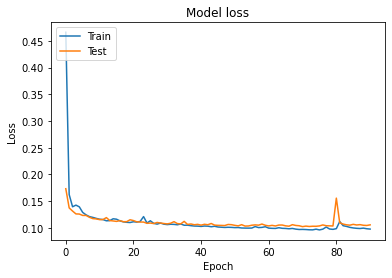

In [15]:
# 预测第一天用药
train_deep(X_train,y_train,X_test,y_test,1, callbacks_list)

create model. feature_dim =2072, label_dim =300
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 512)               1061376   
                                                                 
 dense_10 (Dense)            (None, 512)               262656    
                                                                 
 dense_11 (Dense)            (None, 512)               262656    
                                                                 
 dense_12 (Dense)            (None, 300)               153900    
                                                                 
Total params: 1,740,588
Trainable params: 1,740,588
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
133/133 [==============================] - 3s 17ms/step - loss: 0.3107 - JI: 0.0610 - val_loss: 0.1446 - val_JI: 0.0

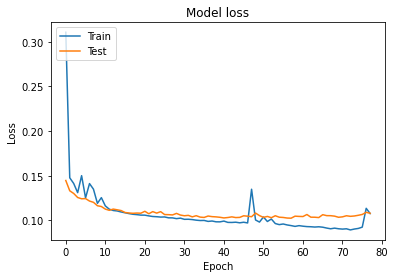

In [16]:
# 预测第一天用药
train_deep(X_train,y_train,X_test,y_test,2, callbacks_list)

create model. feature_dim =2072, label_dim =300
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               1061376   
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 dense_2 (Dense)             (None, 512)               262656    
                                                                 
 dense_3 (Dense)             (None, 512)               262656    
                                                                 
 dense_4 (Dense)             (None, 300)               153900    
                                                                 
Total params: 2,003,244
Trainable params: 2,003,244
Non-trainable params: 0
________________________________________________________________

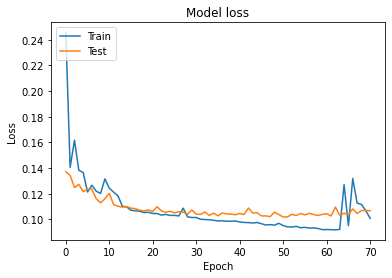

In [5]:
# 预测第一天用药
train_deep(X_train,y_train,X_test,y_test,3, callbacks_list)